In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys 
import os

# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
print(os.getcwd())

import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.dataset import Dataset
from rulevetting.projects.csi_pecarn.tree_functions import *

from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting


/Users/Yaxuan/opt/anaconda3/envs/“rule-env”/lib/python3.7/site-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [2]:
#df_all = Dataset().get_data()
df_ran = Dataset().get_data(control_types=['ran'])
#df_moi = Dataset().get_data(control_types=['moi'])
#df_ems = Dataset().get_data(control_types=['ems'])

In [3]:
av_list = ['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'NonAmbulatory', 'csi_injury']

In [4]:
def data_preparation(df, av, age, outside):
    posthoc_columns = [col for col in df.columns if 'posthoc' in col]
    outside_columns = [col for col in df.columns if 'outside' in col]
    improved_columns = [col for col in df.columns if 'improved' in col]
    pt_columns = [col for col in df.columns if 'Pt' in col]
    AVPU_columns = [col for col in df.columns if 'AVPUDetails_AVPU' in col]
    
    av_list = ['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'NonAmbulatory', 'csi_injury']
    
    
    if age == '<2':
        df = df[df['VeryYoung'] == 1]
    elif age == '2-5':
        df = df[(df['NonVerbal'] == 1) & (df['VeryYoung'] == 0)]
    elif age == '5-12':
        df = df[(df['YoungAdult'] == 0) & (df['NonVerbal'] == 0)]
    elif age == '>12':
        df = df[df['YoungAdult'] == 1]
    elif age == "<5":
        df = df[df['NonVerbal'] == 1]
        
    df = df.drop(['VeryYoung', 'NonVerbal','YoungAdult',
                 'MotorGCS','GCSEye','VerbalGCS','TotalGCS',
                 'Gastrointestinal', 'Cardiovascular','GCS_na'],axis=1).copy()
    # 'ReceivedInTransfer','CervicalSpineImmobilization'
    # 'Gastrointestinal','Cardiovascular'
    df = df.drop(pt_columns,axis=1).copy()
    df = df.drop(AVPU_columns,axis=1).copy()
    
    if av:
        df = df[av_list]
    elif outside:
        df = df.drop(posthoc_columns,axis=1).copy()
        df = df.drop(improved_columns,axis=1).copy() 
    else:
        df = df.drop(posthoc_columns,axis=1).copy()
        df = df.drop(outside_columns,axis=1).copy()  
        df = df.drop(improved_columns,axis=1).copy() 
    
    if age == '<2':
        df = df.drop(['NonAmbulatory'],axis=1).copy()
            
    return df

#### Leonard et al(2011)

The sensitivity and specificity of the rule proposed by Leonard et al(2011) in three control groups

In [5]:
Leonard = ['AlteredMentalStatus','FocalNeuroFindings','PainNeck',
           'Torticollis','SubInj_TorsoTrunk',
           'Predisposed','HighriskDiving','HighriskMVC']

## Decision trees

All models are trained on training set, and evaluate on tuning set.

The plots shows ROC curves for four different classifiers with age stratification:

- CART
- CART with max_depth = 5
- Random Forest
- Simple tree: greedily search high risk features (direcly use the form of decision rule in Leonard(2011) as model)

And the dashed lines mark the FPR and TPR of baselines.(Baselines are training performance)
Notice: TPR = sensitivity, FPR = 1-specificity

## Age > 12

In [6]:
data_list = df_ran
data_train = data_preparation(df_ran[0],av = False, age = '>12', outside = False)
data_tuning = data_preparation(df_ran[1],av = False, age = '>12', outside = False)

frames = [data_train,data_tuning]
result = pd.concat(frames)
result.shape

(445, 36)

In [7]:
data_train.shape

(328, 36)

(328, 36) (117, 36)
(117, 36)
[0.8846153846153846, 0.3384615384615385]
(328, 36)
[0.9219858156028369, 0.34759358288770054]


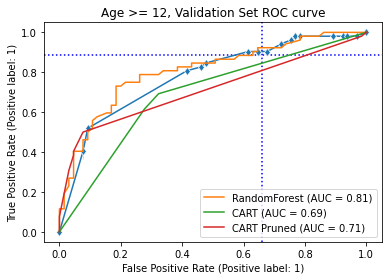

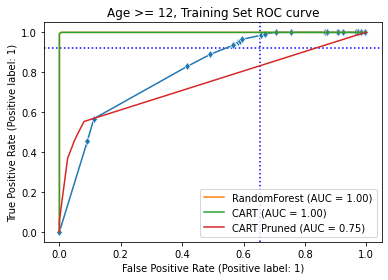

In [8]:
# control group: random

# data preparation --------------
data_list = df_ran
data_train = data_preparation(df_ran[0],av = False, age = '>12', outside = False)
data_tuning = data_preparation(df_ran[1],av = False, age = '>12', outside = False)
print(data_train.shape, data_tuning.shape)

print(data_tuning.shape)
print(evaluate_vlist(data_tuning, Leonard))
print(data_train.shape)
print(evaluate_vlist(data_train, Leonard))

Leo_evaluation = evaluate_vlist(data_tuning, Leonard)
Leo_evaluation_t = evaluate_vlist(data_train, Leonard)

X = data_train.drop(['csi_injury'],axis=1).copy()
y = data_train['csi_injury'].astype('int')
X_tuning = data_tuning.drop(['csi_injury'],axis=1).copy()
y_tuning = data_tuning['csi_injury'].astype('int')

# fiting models ---------------
cart = tree.DecisionTreeClassifier(random_state = 1)
cart = cart.fit(X,y)
cart_small = tree.DecisionTreeClassifier(max_depth = 3,random_state = 1)
cart_small = cart_small.fit(X,y)
rf = RandomForestClassifier(n_estimators = 200,random_state = 1)
rf = rf.fit(X,y)

data_train_s = data_train
results = simple_tree([data_train_s,data_tuning], tree_method = 'one', select_method = "gini")
v = results[0]
e_training = results[1]
e_tuning = results[2]

fig, ax = plt.subplots(figsize=(5.5,4))
ax.axhline(Leo_evaluation[0],linestyle = ":",color = 'blue')
ax.axvline(1-Leo_evaluation[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_tuning, marker='d').set(title = 'Age >= 12, Validation Set ROC curve')
RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(cart, X_tuning, y_tuning, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart_small, X_tuning, y_tuning, ax=ax, name = "CART Pruned")
fig.tight_layout()
plt.savefig('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/tuning12+.pdf')
plt.show()
, 
fig, ax = plt.subplots(figsize=(5.5,4))
ax.axhline(Leo_evaluation_t[0],linestyle = ":",color = 'blue')
ax.axvline(1-Leo_evaluation_t[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_training, marker='d').set(title = 'Age >= 12, Training Set ROC curve')
RocCurveDisplay.from_estimator(rf, X, y, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(cart, X, y, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart_small, X, y, ax=ax, name = "CART Pruned")
fig.tight_layout()
plt.savefig('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/training12+.pdf')
plt.show()

df = pd.DataFrame(data = {'variable': v, 'TPR' :e_tuning['TPR'], 'FPR' :e_tuning['FPR'] })
# df.to_csv('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/12+vlist.csv')

(310, 36) (101, 36)
(101, 36)
[0.9285714285714286, 0.4383561643835616]
(310, 36)
[0.9072164948453608, 0.3568075117370892]


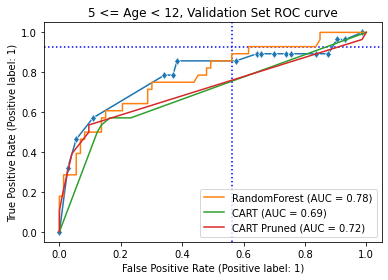

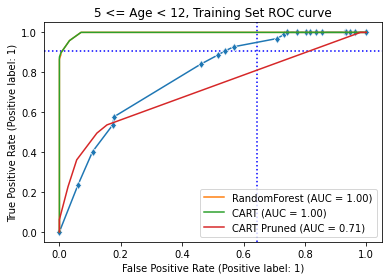

In [9]:
# control group: random

# data preparation --------------
data_list = df_ran
data_train = data_preparation(df_ran[0],av = False, age = '5-12', outside = False)
data_tuning = data_preparation(df_ran[1],av = False, age = '5-12', outside = False)
print(data_train.shape, data_tuning.shape)

print(data_tuning.shape)
print(evaluate_vlist(data_tuning, Leonard))
print(data_train.shape)
print(evaluate_vlist(data_train, Leonard))

Leo_evaluation = evaluate_vlist(data_tuning, Leonard)
Leo_evaluation_t = evaluate_vlist(data_train, Leonard)

X = data_train.drop(['csi_injury'],axis=1).copy()
y = data_train['csi_injury'].astype('int')
X_tuning = data_tuning.drop(['csi_injury'],axis=1).copy()
y_tuning = data_tuning['csi_injury'].astype('int')

# fiting models ---------------
cart = tree.DecisionTreeClassifier(random_state = 1)
cart = cart.fit(X,y)
cart_small = tree.DecisionTreeClassifier(max_depth = 3,random_state = 1)
cart_small = cart_small.fit(X,y)
rf = RandomForestClassifier(n_estimators = 200,random_state = 1)
rf = rf.fit(X,y)

data_train_s = data_train
results = simple_tree([data_train_s,data_tuning], tree_method = 'one', select_method = "gini")
v = results[0]
e_training = results[1]
e_tuning = results[2]

fig, ax = plt.subplots(figsize=(5.5,4))
ax.axhline(Leo_evaluation[0],linestyle = ":",color = 'blue')
ax.axvline(1-Leo_evaluation[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_tuning, marker='d').set(title = '5 <= Age < 12, Validation Set ROC curve')
RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(cart, X_tuning, y_tuning, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart_small, X_tuning, y_tuning, ax=ax, name = "CART Pruned")
fig.tight_layout()
plt.savefig('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/tuning5-12.pdf')
plt.show()
, 
fig, ax = plt.subplots(figsize=(5.5,4))
ax.axhline(Leo_evaluation_t[0],linestyle = ":",color = 'blue')
ax.axvline(1-Leo_evaluation_t[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_training, marker='d').set(title = '5 <= Age < 12, Training Set ROC curve')
RocCurveDisplay.from_estimator(rf, X, y, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(cart, X, y, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart_small, X, y, ax=ax, name = "CART Pruned")
fig.tight_layout()
plt.savefig('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/training5-12.pdf')
plt.show()

df = pd.DataFrame(data = {'variable': v, 'TPR' :e_tuning['TPR'], 'FPR' :e_tuning['FPR'] })
# df.to_csv('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/12+vlist.csv')

(113, 36) (38, 36)
(38, 36)
[1.0, 0.44]
(113, 36)
[1.0, 0.3902439024390244]


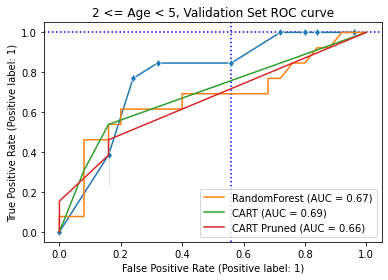

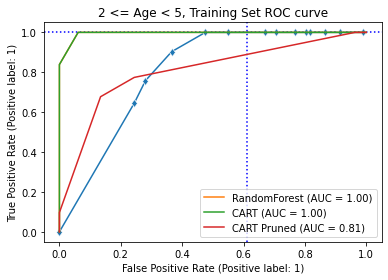

In [10]:
# control group: random

# data preparation --------------
data_list = df_ran
data_train = data_preparation(df_ran[0],av = False, age = '2-5', outside = False)
data_tuning = data_preparation(df_ran[1],av = False, age = '2-5', outside = False)
print(data_train.shape, data_tuning.shape)

print(data_tuning.shape)
print(evaluate_vlist(data_tuning, Leonard))
print(data_train.shape)
print(evaluate_vlist(data_train, Leonard))

Leo_evaluation = evaluate_vlist(data_tuning, Leonard)
Leo_evaluation_t = evaluate_vlist(data_train, Leonard)

X = data_train.drop(['csi_injury'],axis=1).copy()
y = data_train['csi_injury'].astype('int')
X_tuning = data_tuning.drop(['csi_injury'],axis=1).copy()
y_tuning = data_tuning['csi_injury'].astype('int')

# fiting models ---------------
cart = tree.DecisionTreeClassifier(random_state = 1)
cart = cart.fit(X,y)
cart_small = tree.DecisionTreeClassifier(max_depth = 3,random_state = 1)
cart_small = cart_small.fit(X,y)
rf = RandomForestClassifier(n_estimators = 200,random_state = 1)
rf = rf.fit(X,y)

data_train_s = data_train
results = simple_tree([data_train_s,data_tuning], tree_method = 'one', select_method = "gini")
v = results[0]
e_training = results[1]
e_tuning = results[2]

fig, ax = plt.subplots(figsize=(5.5,4))
ax.axhline(Leo_evaluation[0],linestyle = ":",color = 'blue')
ax.axvline(1-Leo_evaluation[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_tuning, marker='d').set(title = '2 <= Age < 5, Validation Set ROC curve')
RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(cart, X_tuning, y_tuning, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart_small, X_tuning, y_tuning, ax=ax, name = "CART Pruned")
fig.tight_layout()
plt.savefig('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/tuning2-5.pdf')
plt.show()
, 
fig, ax = plt.subplots(figsize=(5.5,4))
ax.axhline(Leo_evaluation_t[0],linestyle = ":",color = 'blue')
ax.axvline(1-Leo_evaluation_t[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_training, marker='d').set(title = '2 <= Age < 5, Training Set ROC curve')
RocCurveDisplay.from_estimator(rf, X, y, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(cart, X, y, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart_small, X, y, ax=ax, name = "CART Pruned")
fig.tight_layout()
plt.savefig('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/training2-5.pdf')
plt.show()

df = pd.DataFrame(data = {'variable': v, 'TPR' :e_tuning['TPR'], 'FPR' :e_tuning['FPR'] })
# df.to_csv('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/12+vlist.csv')

(70, 35) (23, 35)
(23, 35)
[1.0, 0.6]
(70, 35)
[0.8571428571428571, 0.7142857142857143]


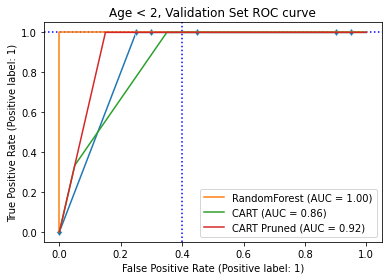

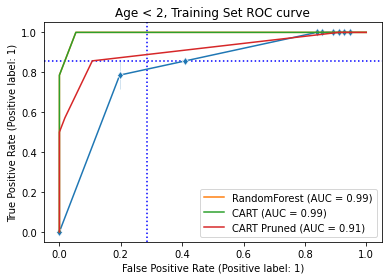

In [11]:
# control group: random

# data preparation --------------
data_list = df_ran
data_train = data_preparation(df_ran[0],av = False, age = '<2', outside = False)
data_tuning = data_preparation(df_ran[1],av = False, age = '<2', outside = False)
print(data_train.shape, data_tuning.shape)

print(data_tuning.shape)
print(evaluate_vlist(data_tuning, Leonard))
print(data_train.shape)
print(evaluate_vlist(data_train, Leonard))

Leo_evaluation = evaluate_vlist(data_tuning, Leonard)
Leo_evaluation_t = evaluate_vlist(data_train, Leonard)

X = data_train.drop(['csi_injury'],axis=1).copy()
y = data_train['csi_injury'].astype('int')
X_tuning = data_tuning.drop(['csi_injury'],axis=1).copy()
y_tuning = data_tuning['csi_injury'].astype('int')

# fiting models ---------------
cart = tree.DecisionTreeClassifier(random_state = 1)
cart = cart.fit(X,y)
cart_small = tree.DecisionTreeClassifier(max_depth = 3,random_state = 1)
cart_small = cart_small.fit(X,y)
rf = RandomForestClassifier(n_estimators = 200,random_state = 1)
rf = rf.fit(X,y)

data_train_s = data_train
results = simple_tree([data_train_s,data_tuning], tree_method = 'one', select_method = "gini")
v = results[0]
e_training = results[1]
e_tuning = results[2]

fig, ax = plt.subplots(figsize=(5.5,4))
ax.axhline(Leo_evaluation[0],linestyle = ":",color = 'blue')
ax.axvline(1-Leo_evaluation[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_tuning, marker='d').set(title = 'Age < 2, Validation Set ROC curve')
RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(cart, X_tuning, y_tuning, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart_small, X_tuning, y_tuning, ax=ax, name = "CART Pruned")
fig.tight_layout()
plt.savefig('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/tuning2-.pdf')
plt.show()
, 
fig, ax = plt.subplots(figsize=(5.5,4))
ax.axhline(Leo_evaluation_t[0],linestyle = ":",color = 'blue')
ax.axvline(1-Leo_evaluation_t[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_training, marker='d').set(title = 'Age < 2, Training Set ROC curve')
RocCurveDisplay.from_estimator(rf, X, y, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(cart, X, y, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart_small, X, y, ax=ax, name = "CART Pruned")
fig.tight_layout()
plt.savefig('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/training2-.pdf')
plt.show()

df = pd.DataFrame(data = {'variable': v, 'TPR' :e_tuning['TPR'], 'FPR' :e_tuning['FPR'] })
# df.to_csv('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/12+vlist.csv')

In [12]:
data_train.columns

Index(['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'PassRestraint', 'Assault', 'ChildAbuse', 'csi_injury',
       'EMSArrival', 'helmet', 'HEENT', 'Respiratory', 'Musculoskeletal',
       'Neurological', 'Medications', 'HighriskFallDownStairs', 'GCSnot15',
       'GCSbelowThreshold'],
      dtype='object')

In [13]:
v

['AlteredMentalStatus',
 'PosMidNeckTenderness',
 'HEENT',
 'AxialLoadAnyDoc',
 'EMSArrival',
 'Predisposed',
 'HighriskFall',
 'Assault',
 'Respiratory',
 'Medications',
 'LOC',
 'FocalNeuroFindings',
 'PainNeck',
 'TenderNeck',
 'Torticollis',
 'SubInj_Head',
 'SubInj_Face',
 'SubInj_Ext',
 'SubInj_TorsoTrunk',
 'HighriskDiving',
 'HighriskHanging',
 'HighriskHitByCar',
 'HighriskMVC',
 'HighriskOtherMV',
 'axialloadtop',
 'Clotheslining',
 'PassRestraint',
 'ChildAbuse',
 'helmet',
 'Musculoskeletal',
 'Neurological',
 'HighriskFallDownStairs',
 'GCSnot15',
 'GCSbelowThreshold']

## 5 < Age < 12

(310, 36) (101, 36)
(101, 36)
[0.9285714285714286, 0.4383561643835616]
(310, 36)
[0.9072164948453608, 0.3568075117370892]


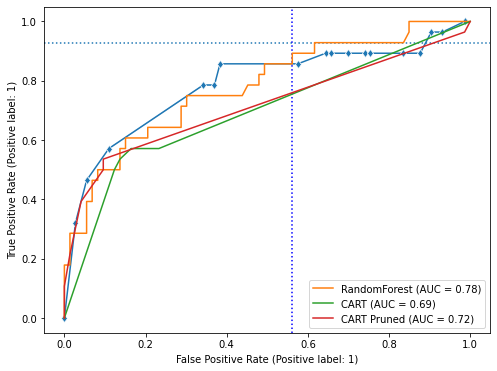

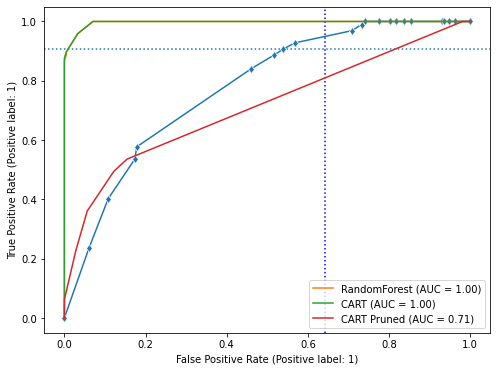

In [14]:
# control group: random

# data preparation --------------
data_list = df_ran
data_train = data_preparation(df_ran[0],av = False, age = '5-12', outside = False)
data_tuning = data_preparation(df_ran[1],av = False, age = '5-12', outside = False)
print(data_train.shape, data_tuning.shape)

print(data_tuning.shape)
print(evaluate_vlist(data_tuning, Leonard))
print(data_train.shape)
print(evaluate_vlist(data_train, Leonard))

Leo_evaluation = evaluate_vlist(data_tuning, Leonard)
Leo_evaluation_t = evaluate_vlist(data_train, Leonard)

X = data_train.drop(['csi_injury'],axis=1).copy()
y = data_train['csi_injury'].astype('int')
X_tuning = data_tuning.drop(['csi_injury'],axis=1).copy()
y_tuning = data_tuning['csi_injury'].astype('int')

# fiting models ---------------
cart = tree.DecisionTreeClassifier(random_state = 1)
cart = cart.fit(X,y)
cart_small = tree.DecisionTreeClassifier(max_depth = 3,random_state = 1)
cart_small = cart_small.fit(X,y)
rf = RandomForestClassifier(n_estimators = 200,random_state = 1)
rf = rf.fit(X,y)

data_train_s = data_train
results = simple_tree([data_train_s,data_tuning], tree_method = 'one', select_method = "gini")
v = results[0]
e_training = results[1]
e_tuning = results[2]

fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_tuning, marker='d')
RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(cart, X_tuning, y_tuning, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart_small, X_tuning, y_tuning, ax=ax, name = "CART Pruned")
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation_t[0],linestyle = ":")
ax.axvline(1-Leo_evaluation_t[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_training, marker='d')
RocCurveDisplay.from_estimator(rf, X, y, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(cart, X, y, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart_small, X, y, ax=ax, name = "CART Pruned")
plt.show()

df = pd.DataFrame(data = {'variable': v, 'TPR' :e_tuning['TPR'], 'FPR' :e_tuning['FPR'] })
df.to_csv('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/5-12vlist.csv')

## 2 < Age < 5

(113, 36) (38, 36)
(38, 36)
[1.0, 0.44]
(113, 36)
[1.0, 0.3902439024390244]


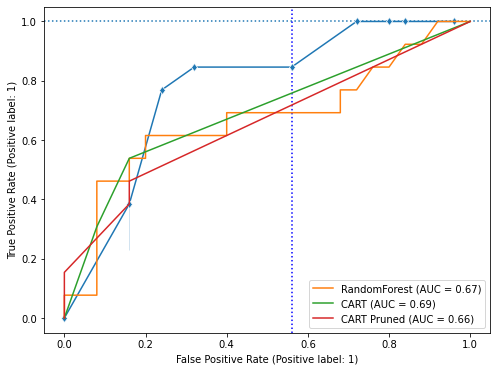

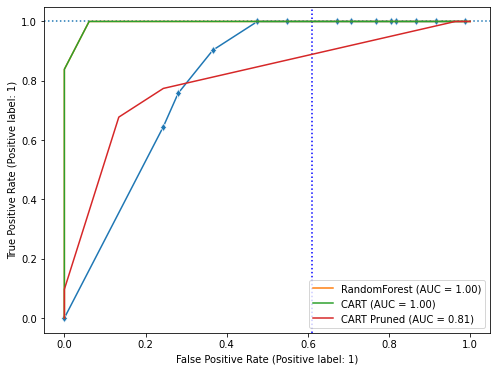

In [15]:
# control group: random

# data preparation --------------
data_list = df_ran
data_train = data_preparation(df_ran[0],av = False, age = '2-5', outside = False)
data_tuning = data_preparation(df_ran[1],av = False, age = '2-5', outside = False)
print(data_train.shape, data_tuning.shape)

print(data_tuning.shape)
print(evaluate_vlist(data_tuning, Leonard))
print(data_train.shape)
print(evaluate_vlist(data_train, Leonard))

Leo_evaluation = evaluate_vlist(data_tuning, Leonard)
Leo_evaluation_t = evaluate_vlist(data_train, Leonard)

X = data_train.drop(['csi_injury'],axis=1).copy()
y = data_train['csi_injury'].astype('int')
X_tuning = data_tuning.drop(['csi_injury'],axis=1).copy()
y_tuning = data_tuning['csi_injury'].astype('int')

# fiting models ---------------
cart = tree.DecisionTreeClassifier(random_state = 1)
cart = cart.fit(X,y)
cart_small = tree.DecisionTreeClassifier(max_depth = 3,random_state = 1)
cart_small = cart_small.fit(X,y)
rf = RandomForestClassifier(n_estimators = 200,random_state = 1)
rf = rf.fit(X,y)

data_train_s = data_train
results = simple_tree([data_train_s,data_tuning], tree_method = 'one', select_method = "gini")
v = results[0]
e_training = results[1]
e_tuning = results[2]

fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_tuning, marker='d')
RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(cart, X_tuning, y_tuning, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart_small, X_tuning, y_tuning, ax=ax, name = "CART Pruned")
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation_t[0],linestyle = ":")
ax.axvline(1-Leo_evaluation_t[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_training, marker='d')
RocCurveDisplay.from_estimator(rf, X, y, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(cart, X, y, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart_small, X, y, ax=ax, name = "CART Pruned")
plt.show()

df = pd.DataFrame(data = {'variable': v, 'TPR' :e_tuning['TPR'], 'FPR' :e_tuning['FPR'] })
df.to_csv('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/2-5vlist.csv')

## Age < 2

(70, 35) (23, 35)
(23, 35)
[1.0, 0.6]
(70, 35)
[0.8571428571428571, 0.7142857142857143]


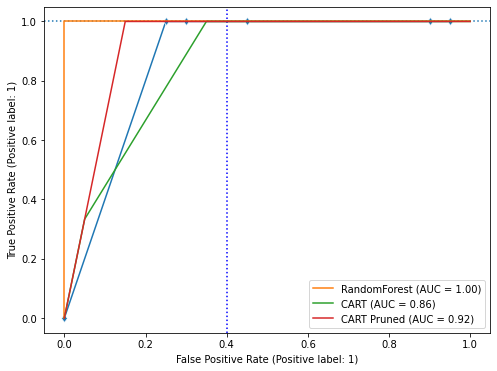

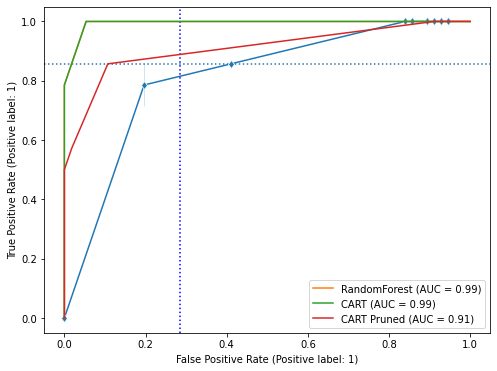

In [16]:
# control group: random

# data preparation --------------
data_list = df_ran
data_train = data_preparation(df_ran[0],av = False, age = '<2', outside = False)
data_tuning = data_preparation(df_ran[1],av = False, age = '<2', outside = False)
print(data_train.shape, data_tuning.shape)

print(data_tuning.shape)
print(evaluate_vlist(data_tuning, Leonard))
print(data_train.shape)
print(evaluate_vlist(data_train, Leonard))

Leo_evaluation = evaluate_vlist(data_tuning, Leonard)
Leo_evaluation_t = evaluate_vlist(data_train, Leonard)

X = data_train.drop(['csi_injury'],axis=1).copy()
y = data_train['csi_injury'].astype('int')
X_tuning = data_tuning.drop(['csi_injury'],axis=1).copy()
y_tuning = data_tuning['csi_injury'].astype('int')

# fiting models ---------------
cart = tree.DecisionTreeClassifier(random_state = 1)
cart = cart.fit(X,y)
cart_small = tree.DecisionTreeClassifier(max_depth = 3,random_state = 1)
cart_small = cart_small.fit(X,y)
rf = RandomForestClassifier(n_estimators = 200,random_state = 1)
rf = rf.fit(X,y)

data_train_s = data_train
results = simple_tree([data_train_s,data_tuning], tree_method = 'one', select_method = "gini")
v = results[0]
e_training = results[1]
e_tuning = results[2]

fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation[0],linestyle = ":")
ax.axvline(1-Leo_evaluation[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_tuning, marker='d')
RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(cart, X_tuning, y_tuning, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart_small, X_tuning, y_tuning, ax=ax, name = "CART Pruned")
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(Leo_evaluation_t[0],linestyle = ":")
ax.axvline(1-Leo_evaluation_t[1],linestyle = ":",color = 'blue')
sns.lineplot(x='FPR', y= 'TPR', data = e_training, marker='d')
RocCurveDisplay.from_estimator(rf, X, y, ax=ax, name = "RandomForest")
RocCurveDisplay.from_estimator(cart, X, y, ax=ax, name = "CART")
RocCurveDisplay.from_estimator(cart_small, X, y, ax=ax, name = "CART Pruned")
plt.show()

df = pd.DataFrame(data = {'variable': v, 'TPR' :e_tuning['TPR'], 'FPR' :e_tuning['FPR'] })
df.to_csv('/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/notebooks/figs/2-vlist.csv')

### Summary

- Two issues in Leonard(2011)
    - Their error is fitting error. (They use the whole dataset to train the model. This can partly explain why their model is very stable. But we cannot test how it perform in real prediction.)
    - We don't know how they deal with missing data from the paper. (Using their model, I cannot repeat their result, 94%/32% & 98%/26%. In my testing, it don't have a such high overall sensitivity. Maybe they only use complete data.)

- I use 'semi-gini'(just the simple rate in one side) instead of 'gini' when building tree
    - 'gini' consider equally about both sides, but for us, one side is decision rule while the other side will be devided further.
    - 'semi-gini' can catch some factors that are not common but with high risk.
    - use one variable at one time (I just don't have time to explore more complex algorithm)
    
- Sample size problem
    - the sample sizes of '<2' and '2-5' groups are so small, especially the tuning set. Maybe can not give reliable model or performanve evaluation.
    - Now I train model on training set, and choose threshold in tuning set. I don't know if this is a good idea because tuning sets are small after age stratification.
    
- Comparison of ST/CART/RF
    - Performance: ST >= RF >> CART
    - Interpretability: ST >= CART >> RF
    - The performance of ST and RF are similar: only small part of structures of RF are really helpful for prediction.
    - CART use greedy in a whole large tree sets, not optimal; RF combine 200 trees and explore more possibility. (They are all overfitting in training set)
    - The structure of ST: use Age as the first layer, and then go deep in each subnodes. This kind of tree is very deep and asymmetric. (CART are supposed to be much more balanced, so difficult for cart to search this kind of structure)
    - idea of ST: use domain knowledge and judgement call to give some constraints on tree stucture, and then fit it greedly.
    
#### Question

- which level of sensitivity is acceptable in clinic rules?
- Outside variables? (like ReceivedInTransfer, CervicalSpineImmobilization)
    - They will improve model perfomance(not slightly), but I just feel uncomfortable using them.
